In [ ]:
import numpy as np
import pandas as pd
import random
import io
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,cohen_kappa_score,matthews_corrcoef
from sklearn.model_selection import train_test_split
from IPython.display import Image,display,clear_output
import pywt

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from collections import Counter

import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras import Model, layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout,Dense,Input,Conv2D,MaxPooling2D,Flatten,Activation

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Number of images in training:  4000
Number of images in testing:  1200


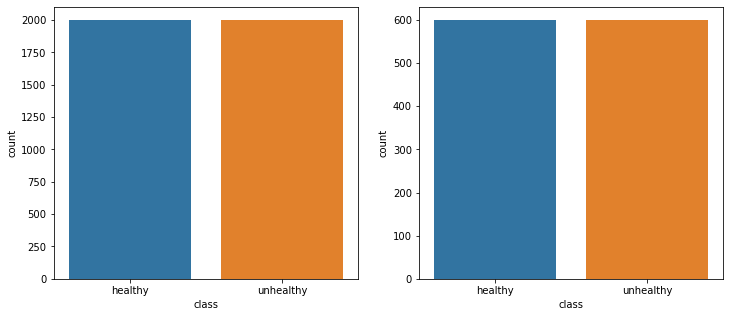

In [ ]:
root_path = 'D:\\New folder\\'
labels = []
trainFolder = root_path+'\\Train\\'
testFolder = root_path+'\\Test\\'

quantity_tr = {}
quantity_te = {}
for folder in os.listdir(trainFolder):
    quantity_tr[folder] = len(os.listdir(trainFolder+folder))
    labels.append(folder)

for folder in os.listdir(testFolder):
    quantity_te[folder] = len(os.listdir(testFolder+folder))


quantity_train = pd.DataFrame(list(quantity_tr.items()),
                              index=range(0,len(quantity_tr)), columns=['class','count'])

quantity_test = pd.DataFrame(list(quantity_te.items()),
                              index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(12,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in training: ", sum(quantity_tr.values()))
print("Number of images in testing: ", sum(quantity_te.values()))

plt.show()

In [ ]:
img_height = img_width = 128
batch_size = 32
labels

['healthy', 'unhealthy']

In [ ]:
X_train = []
y_train = []

X_test = []
y_test = []

for i in labels:
    folderPath = os.path.join(root_path,'Train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(img_height, img_width))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join(root_path,'Test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(img_height, img_width))
        X_test.append(img)
        y_test.append(i)

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 577.52it/s]


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
print(np.min(X_train), np.max(X_train))

0 255


In [ ]:
X_train=X_train/255.0
X_test=X_test/255.0

In [ ]:
print(np.min(X_train), np.max(X_train))

0.0 1.0


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4000, 128, 128, 3) (4000,)
(1200, 128, 128, 3) (1200,)


In [ ]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4000, 128, 128, 3) (4000, 2)
(1200, 128, 128, 3) (1200, 2)


In [ ]:
train_datagen = ImageDataGenerator(
        fill_mode="nearest",
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1
)
test_datagen = ImageDataGenerator()


train_ds = train_datagen.flow(
  X_train, y_train,
  subset="training",
  shuffle=True,
  batch_size=batch_size)

In [ ]:
val_ds = train_datagen.flow(
  X_train, y_train,
  subset="validation",
  shuffle=True,
  batch_size=batch_size)

In [ ]:
test_ds = test_datagen.flow(
  X_test, y_test,
  shuffle=False,
  batch_size=batch_size)

In [ ]:
j = 0
class_mapping = {}
for i in labels:
    class_mapping[j] = i
    j+=1

class_mapping

{0: 'healthy', 1: 'unhealthy'}

In [ ]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(testFolder)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(testFolder)):
        image_ids = os.listdir(os.path.join(testFolder,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:

            display = cv2.imread(os.path.join(testFolder,folder,image_ids[j]),1)
            display = cv2.resize(display, (img_height, img_width))/255.0
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True: '+folder
            if(predict_using_model):
                result = predict_using_model.predict(np.array([display]))
                #print(result)
                acc = str(round(np.max(result)*100, 3))
                predicted_classname = class_mapping[np.argmax(result)]
                title = title+'\nPrediction : '+predicted_classname+" - "+acc+"%"
            ax1[axs].set_title(title)
            axs=axs+1

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 3)
(32, 2)


In [ ]:
tf.keras.backend.clear_session()
epoch = 5

In [ ]:
def create_model(input_shape=(img_height, img_width, 3), n_classes = len(labels), optimizer='adam', fine_tune=0):


    conv_base = ResNet50(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)



    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False


    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='sigmoid')(top_model)


    model = Model(inputs=conv_base.input, outputs=output_layer)



    return model
resnet50_final_model = create_model(fine_tune=0)
resnet50_final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
callbacks = [
tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                     patience=5,
                                     min_lr=0.000001,
                                     verbose=1)]

Metrics=['accuracy',
         [tf.keras.metrics.AUC(name='auc')],
         [tf.keras.metrics.Recall(name='recall')],
         [tf.keras.metrics.Precision(name='precision')]]

In [ ]:
resnet50_final_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=Metrics)

In [ ]:
resnet50_history = resnet50_final_model.fit(train_ds,
                                epochs = epoch,
                                validation_data = val_ds,
                                callbacks=callbacks,
                                verbose=1)

Epoch 1/5
113/113 [==============================] - 44s 366ms/step - loss: 0.7402 - accuracy: 0.5317 - auc: 0.5342 - recall: 0.5603 - precision: 0.5250 - val_loss: 0.6861 - val_accuracy: 0.5100 - val_auc: 0.5984 - val_recall: 0.5650 - val_precision: 0.5183 - lr: 0.0010
Epoch 2/5
113/113 [==============================] - 40s 356ms/step - loss: 0.6882 - accuracy: 0.5447 - auc: 0.5517 - recall: 0.5539 - precision: 0.5442 - val_loss: 0.6888 - val_accuracy: 0.4950 - val_auc: 0.5830 - val_recall: 0.4950 - val_precision: 0.4950 - lr: 0.0010
Epoch 3/5
113/113 [==============================] - 41s 358ms/step - loss: 0.6881 - accuracy: 0.5383 - auc: 0.5541 - recall: 0.5406 - precision: 0.5377 - val_loss: 0.6837 - val_accuracy: 0.5400 - val_auc: 0.6130 - val_recall: 0.5550 - val_precision: 0.5428 - lr: 0.0010
Epoch 4/5
113/113 [==============================] - 41s 360ms/step - loss: 0.6802 - accuracy: 0.5444 - auc: 0.5803 - recall: 0.5425 - precision: 0.5442 - val_loss: 0.6630 - val_accuracy:

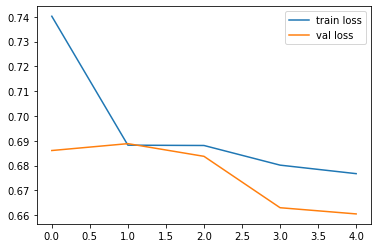

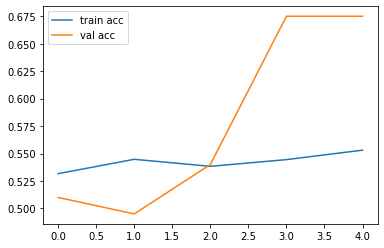

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(resnet50_history.history['loss'], label='train loss')
plt.plot(resnet50_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(resnet50_history.history['accuracy'], label='train acc')
plt.plot(resnet50_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input

In [ ]:
def create_model(input_shape=(img_height, img_width, 3), n_classes = len(labels), optimizer='adam', fine_tune=0):


    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)



    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False


    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='sigmoid')(top_model)


    model = Model(inputs=conv_base.input, outputs=output_layer)



    return model
vgg16_final_model = create_model(fine_tune=0)
vgg16_final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
callbacks = [
tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                     patience=5,
                                     min_lr=0.000001,
                                     verbose=1)]

Metrics=['accuracy',
         [tf.keras.metrics.AUC(name='auc')],
         [tf.keras.metrics.Recall(name='recall')],
         [tf.keras.metrics.Precision(name='precision')]]

In [ ]:
vgg16_final_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=Metrics)

In [ ]:
vgg16_history = vgg16_final_model.fit(train_ds,
                                epochs = epoch,
                                validation_data = val_ds,
                                callbacks=callbacks,
                                verbose=1)

Epoch 1/5
113/113 [==============================] - 73s 639ms/step - loss: 0.4300 - accuracy: 0.8183 - auc: 0.8849 - recall: 0.8069 - precision: 0.8094 - val_loss: 0.2283 - val_accuracy: 0.9100 - val_auc: 0.9742 - val_recall: 0.9225 - val_precision: 0.9044 - lr: 0.0010
Epoch 2/5
113/113 [==============================] - 72s 636ms/step - loss: 0.2614 - accuracy: 0.8964 - auc: 0.9595 - recall: 0.8953 - precision: 0.8945 - val_loss: 0.1743 - val_accuracy: 0.9350 - val_auc: 0.9840 - val_recall: 0.9400 - val_precision: 0.9307 - lr: 0.0010
Epoch 3/5
113/113 [==============================] - 72s 637ms/step - loss: 0.2048 - accuracy: 0.9228 - auc: 0.9751 - recall: 0.9239 - precision: 0.9226 - val_loss: 0.1586 - val_accuracy: 0.9475 - val_auc: 0.9861 - val_recall: 0.9475 - val_precision: 0.9547 - lr: 0.0010
Epoch 4/5
113/113 [==============================] - 72s 637ms/step - loss: 0.1799 - accuracy: 0.9300 - auc: 0.9807 - recall: 0.9322 - precision: 0.9309 - val_loss: 0.1960 - val_accuracy:

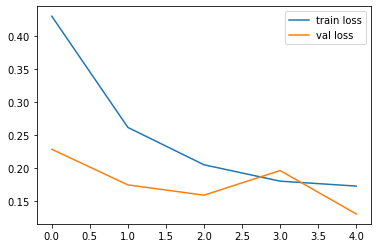

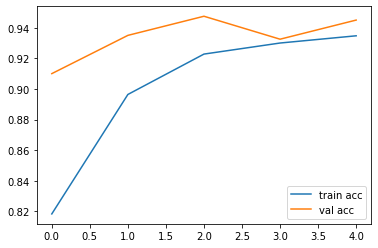

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(vgg16_history.history['loss'], label='train loss')
plt.plot(vgg16_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(vgg16_history.history['accuracy'], label='train acc')
plt.plot(vgg16_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet , preprocess_input

In [ ]:
def create_model(input_shape=(img_height, img_width, 3), n_classes = len(labels), optimizer='adam', fine_tune=0):

    conv_base = MobileNet(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)


    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False


    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='sigmoid')(top_model)

    model = Model(inputs=conv_base.input, outputs=output_layer)

    return model
mobilenet_final_model = create_model(fine_tune=0)
mobilenet_final_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                    

In [ ]:
callbacks = [
tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                     patience=5,
                                     min_lr=0.000001,
                                     verbose=1)]

Metrics=['accuracy',
         [tf.keras.metrics.AUC(name='auc')],
         [tf.keras.metrics.Recall(name='recall')],
         [tf.keras.metrics.Precision(name='precision')]]

In [ ]:
mobilenet_final_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=Metrics)

In [ ]:
mobilenet_history = mobilenet_final_model.fit(train_ds,
                                epochs = epoch,
                                validation_data = val_ds,
                                callbacks=callbacks,
                                verbose=1)

Epoch 1/5
113/113 [==============================] - 16s 131ms/step - loss: 0.5493 - accuracy: 0.8794 - auc: 0.9263 - recall: 0.8800 - precision: 0.8761 - val_loss: 0.0993 - val_accuracy: 0.9625 - val_auc: 0.9938 - val_recall: 0.9650 - val_precision: 0.9578 - lr: 0.0010
Epoch 2/5
113/113 [==============================] - 14s 126ms/step - loss: 0.1441 - accuracy: 0.9558 - auc: 0.9870 - recall: 0.9517 - precision: 0.9477 - val_loss: 0.1431 - val_accuracy: 0.9450 - val_auc: 0.9887 - val_recall: 0.9350 - val_precision: 0.9565 - lr: 0.0010
Epoch 3/5
113/113 [==============================] - 14s 126ms/step - loss: 0.1221 - accuracy: 0.9583 - auc: 0.9900 - recall: 0.9544 - precision: 0.9560 - val_loss: 0.1182 - val_accuracy: 0.9650 - val_auc: 0.9882 - val_recall: 0.9725 - val_precision: 0.9629 - lr: 0.0010
Epoch 4/5
113/113 [==============================] - 15s 129ms/step - loss: 0.1106 - accuracy: 0.9611 - auc: 0.9918 - recall: 0.9608 - precision: 0.9603 - val_loss: 0.0905 - val_accuracy:

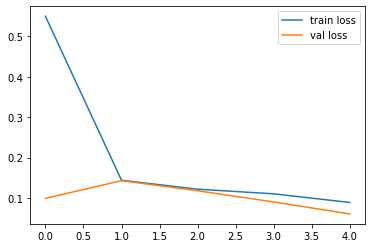

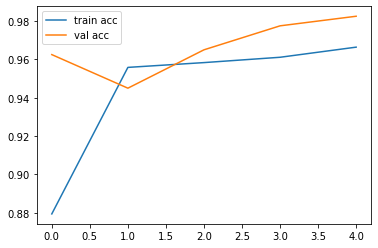

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(mobilenet_history.history['loss'], label='train loss')
plt.plot(mobilenet_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(mobilenet_history.history['accuracy'], label='train acc')
plt.plot(mobilenet_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19 , preprocess_input

In [ ]:
def create_model(input_shape=(img_height, img_width, 3), n_classes = len(labels), optimizer='adam', fine_tune=0):

    conv_base = VGG19(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='sigmoid')(top_model)

    model = Model(inputs=conv_base.input, outputs=output_layer)

    return model
vgg19_final_model = create_model(fine_tune=0)
vgg19_final_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
callbacks = [
tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                     patience=5,
                                     min_lr=0.000001,
                                     verbose=1)]

Metrics=['accuracy',
         [tf.keras.metrics.AUC(name='auc')],
         [tf.keras.metrics.Recall(name='recall')],
         [tf.keras.metrics.Precision(name='precision')]]

In [ ]:
vgg19_final_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=Metrics)

In [ ]:
vgg19_history = vgg19_final_model.fit(train_ds,
                                epochs = epoch,
                                validation_data = val_ds,
                                callbacks=callbacks,
                                verbose=1)

Epoch 1/5
113/113 [==============================] - 92s 802ms/step - loss: 0.4646 - accuracy: 0.8003 - auc: 0.8682 - recall: 0.8039 - precision: 0.7914 - val_loss: 0.2367 - val_accuracy: 0.9250 - val_auc: 0.9733 - val_recall: 0.9175 - val_precision: 0.9315 - lr: 0.0010
Epoch 2/5
113/113 [==============================] - 90s 796ms/step - loss: 0.2637 - accuracy: 0.9006 - auc: 0.9594 - recall: 0.9019 - precision: 0.8925 - val_loss: 0.1706 - val_accuracy: 0.9400 - val_auc: 0.9856 - val_recall: 0.9325 - val_precision: 0.9419 - lr: 0.0010
Epoch 3/5
113/113 [==============================] - 90s 792ms/step - loss: 0.2111 - accuracy: 0.9139 - auc: 0.9736 - recall: 0.9111 - precision: 0.9144 - val_loss: 0.1390 - val_accuracy: 0.9550 - val_auc: 0.9899 - val_recall: 0.9575 - val_precision: 0.9527 - lr: 0.0010
Epoch 4/5
113/113 [==============================] - 90s 793ms/step - loss: 0.1975 - accuracy: 0.9239 - auc: 0.9765 - recall: 0.9231 - precision: 0.9228 - val_loss: 0.1226 - val_accuracy:

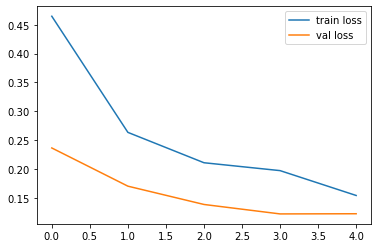

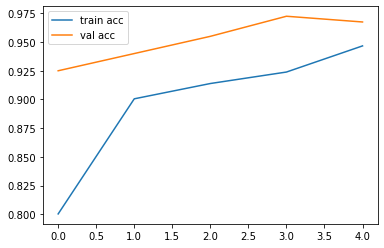

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(vgg19_history.history['loss'], label='train loss')
plt.plot(vgg19_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(vgg19_history.history['accuracy'], label='train acc')
plt.plot(vgg19_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.layers import Input, Average

In [ ]:
resnet50_final_model = Model(inputs=resnet50_final_model.inputs,
                outputs=resnet50_final_model.outputs,
                name='name_of_model_1')

vgg16_final_model = Model(inputs=vgg16_final_model.inputs,
                outputs=vgg16_final_model.outputs,
                name='name_of_model_2')
mobilenet_final_model = Model(inputs=mobilenet_final_model.inputs,
                outputs=mobilenet_final_model.outputs,
                name='name_of_model_3')
vgg19_final_model = Model(inputs=vgg19_final_model.inputs,
                outputs=vgg19_final_model.outputs,
                name='name_of_model_4')
models = [resnet50_final_model, vgg16_final_model,mobilenet_final_model, vgg19_final_model]

In [ ]:
model_input = Input(shape=(128, 128, 3))

In [ ]:
model_outputs = [model(model_input) for model in models]

In [ ]:
ensemble_output = Average()(model_outputs)

In [ ]:
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [ ]:
callbacks = [
tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                     patience=5,
                                     min_lr=0.000001,
                                     verbose=1)]

Metrics=['accuracy',
         [tf.keras.metrics.AUC(name='auc')],
         [tf.keras.metrics.Recall(name='recall')],
         [tf.keras.metrics.Precision(name='precision')]]

In [ ]:
ensemble_model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=Metrics
)

In [ ]:
ensemble_history = ensemble_model.fit(train_ds,
                                epochs = 20,
                                validation_data = val_ds,
                                callbacks=callbacks,
                                verbose=1)

Epoch 1/20
113/113 [==============================] - 198s 2s/step - loss: 0.2102 - accuracy: 0.9681 - auc: 0.9936 - recall: 0.9678 - precision: 0.9675 - val_loss: 0.1896 - val_accuracy: 0.9725 - val_auc: 0.9890 - val_recall: 0.9725 - val_precision: 0.9725 - lr: 0.0010
Epoch 2/20
113/113 [==============================] - 197s 2s/step - loss: 0.2036 - accuracy: 0.9689 - auc: 0.9947 - recall: 0.9669 - precision: 0.9699 - val_loss: 0.1918 - val_accuracy: 0.9725 - val_auc: 0.9931 - val_recall: 0.9725 - val_precision: 0.9725 - lr: 0.0010
Epoch 3/20
113/113 [==============================] - 196s 2s/step - loss: 0.1974 - accuracy: 0.9717 - auc: 0.9929 - recall: 0.9717 - precision: 0.9722 - val_loss: 0.1695 - val_accuracy: 0.9750 - val_auc: 0.9953 - val_recall: 0.9750 - val_precision: 0.9750 - lr: 0.0010
Epoch 4/20
113/113 [==============================] - 196s 2s/step - loss: 0.1900 - accuracy: 0.9767 - auc: 0.9956 - recall: 0.9750 - precision: 0.9777 - val_loss: 0.1706 - val_accuracy: 0.9

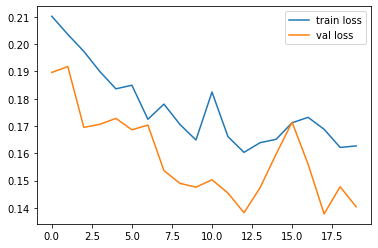

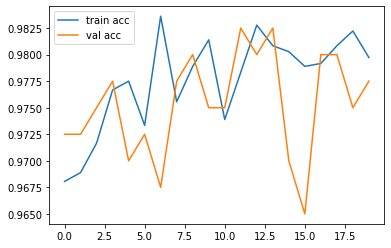

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(ensemble_history.history['loss'], label='train loss')
plt.plot(ensemble_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(ensemble_history.history['accuracy'], label='train acc')
plt.plot(ensemble_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
labels_pred= ensemble_model.predict(test_ds)

In [ ]:
y_pred = tf.argmax(labels_pred, axis=1)
# y_pred

In [ ]:
y_true = tf.argmax(y_test, axis = 1)
# y_true

              precision    recall  f1-score   support

     healthy       0.90      0.96      0.93       600
   unhealthy       0.96      0.89      0.92       600

    accuracy                           0.93      1200
   macro avg       0.93      0.93      0.93      1200
weighted avg       0.93      0.93      0.93      1200



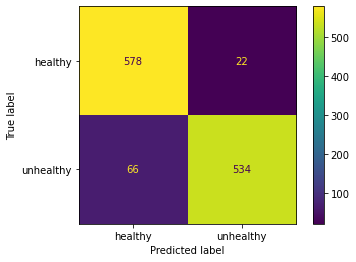

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
plt.show()